In [1]:
import operator
# from typing_extensions import TypedDict
from typing import List, Annotated, Optional
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langchain_core.documents import Document

class GraphState(BaseModel):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    # question: str  # User question
    messages: Annotated[list, add_messages]
    # generation: Optional[str] = Field(description="LLM generation", default=None) # LLM generation
    agent: Optional[str] = Field(description="Binary decision to run agent", default=None)  # Binary decision to run agent
    max_retries: Optional[int] = Field(description="", default=None)  # Max number of retries for answer generation
    answers: Optional[int] = Field(description="", default=None) # Number of answers generated
    loop_step: Optional[Annotated[int, operator.add]] = Field(description="", default=0)  # Loop step for retrying
    documents: Optional[List[Document]] = Field(description="", default=None)  # List of retrieved documents

In [2]:
from pydantic import BaseModel, Field

# Pydantic models for structured output

class RouteResponse(BaseModel):
    """Response of the route"""
    datasource: str = Field(description="The data source used to answer the question")
    
class RetriverScore(BaseModel):
    """Result of PDF reader"""
    score: str = Field(description="The score of the retriever")


class DocGraderResponse(BaseModel):
    """Result of document grader"""
    score: str = Field(description="The score of the document grader")
    documents: list[str] = Field(description="List of documents used for the answer")

class LLMResponse(BaseModel):
    """Result of LLM model"""
    generation: str = Field(description="The generated text from the LLM")

In [6]:
import logging

from typing import Optional
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    HumanMessage,
    filter_messages
)

# System level instructions
INITIAL_INSTRUCTION = """
You are a professional equity research analyst. Analyze the stock by a given stock name or code based on its latest quarterly earnings, valuation metrics (P/E, P/S, EV/EBITDA), competitive positioning, and current macroeconomic trends. Include the following in your report:

1. Company Overview – brief business summary and key revenue streams

2. Recent Financial Performance – revenue, EPS, margins (QoQ and YoY)

3. Valuation Comparison 

4. Technical Analysis – key support/resistance levels, moving averages

5. Catalysts & Risks – what might drive the stock price up or down in the next 6–12 months

6. Buy/Hold/Sell Recommendation – with a price target and rationale

7. Source - where the data come from, either from local provided file or web search


"""

def get_llm(outputModel: Optional[BaseModel] = None):
    """
    Get LLM instance based on the output schema
    """
    if outputModel is None:
        llm = ChatOpenAI(
            model="gpt-4o",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2
            # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
            # base_url="...",
            # organization="...",
            # other params...
        )
    else:
        llm = ChatOpenAI(
            model="gpt-4o",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2
            # api_key="...",  # if you prefer to pass api key in directly instaed of using env vars
            # base_url="...",
            # organization="...",
            # other params...
        ).with_structured_output(outputModel)
    return llm

def get_last_human_message(messages):
    """get last human message

    Args:
        messages messages list

    Returns:
        last human message
    """
    return filter_messages(messages, include_types=[HumanMessage])[-1]

# Post-processing
def format_docs(docs):
    """format the documents into a single string

    Args:
        docs (_type_): _description_

    Returns:
        _type_: _description_
    """
    return "\n\n".join(doc.page_content for doc in docs)


In [7]:
import logging
from typing import Annotated

from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.prebuilt import InjectedState

load_dotenv()

# Setup module logger
logger = logging.getLogger(__name__)

# Set embeddings
embd = OpenAIEmbeddings()


def read_pdfs_and_split():
    """Read PDF files from a predefined directory, split them into smaller chunks, and return the chunks.

    Returns:
        _type_: _description_
    """
    filename = "/Users/james/projects/learnings/AI_Learnings/langchain/langgraph-test/data_sources/2025q1-alphabet-earnings-release.pdf"
    loader = PyPDFLoader(file_path=filename)
    docs = []
    docs = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000, chunk_overlap=30, add_start_index=True
    )

    all_splits = text_splitter.split_documents(docs)

    logger.info(f"Split the pdf into {len(all_splits)} sub-documents.")
    return all_splits


def retrieve_documents(state: Annotated[GraphState, InjectedState]):
    """Read documents, split them, and add to vectorstore.

    Args:

    Returns:
        Updated prompt
    """

    all_splits = read_pdfs_and_split()

    # Add to vectorstore
    vectorstore = Chroma.from_documents(
        documents=all_splits,
        collection_name="rag-chroma",
        embedding=embd,
    )
    retriever = vectorstore.as_retriever()
    # Write retrieved documents to documents key in state
    question = get_last_human_message(state.messages).content
    documents = retriever.get_relevant_documents(question)
    return { "documents": documents }
  
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    # Doc grader instructions
    doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""


    # Grader prompt
    doc_grader_prompt = """
    Here is the retrieved document: \n\n {document} \n\n 
    Here is the user question: \n\n {question}. 
    
    This carefully and objectively assess whether the document contains at least some information that is relevant to the question.
    
    Return DocGraderResponse response, score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question.
    """


    logger.info("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    last_message = get_last_human_message(state.messages)
    question = last_message.content
    documents = state.documents

    # Score each doc
    filtered_docs = []
    agent = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = get_llm(DocGraderResponse).invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = result.score
        # Document relevant
        if grade.lower() == "yes":
            logger.info("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            logger.info("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            agent = "Yes"
            continue
    return {"documents": filtered_docs, "agent": agent}
  
def generate_answer(state):
    """
    Generate an answer based on the retrieved documents and the user question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    logger.info("---GENERATE---")
    
    generate_prompt = """
    Here is the retrieved document: \n\n {document} \n\n 
    Here is the user question: \n\n {question}. 
    
    Find the answer for the given question in the document context,
    If there is no relevant information in the document, please say "I don't know".
    
    Return LLMResponse.
    """
    
    question = get_last_human_message(state.messages).content
    documents = state.documents
    # loop_step = state.get("loop_step", 0)
    # print(INITIAL_INSTRUCTION)
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = generate_prompt.format(document=docs_txt, question=question)
    response = get_llm(LLMResponse).invoke(
      [SystemMessage(content=INITIAL_INSTRUCTION)] 
      + [HumanMessage(content=rag_prompt_formatted)])
#    generation = "dummy generation"
    return { "messages": ("user", response.generation) }

In [10]:
import logging
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv

load_dotenv()
logger = logging.getLogger()

def llm_search(state: GraphState):
    """
    Call the LLM model to generate an answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    logger.info("---Calling Agent---")
    last_message = get_last_human_message(state.messages)
    messages = last_message.content
    response = get_llm(LLMResponse).invoke(messages)
    
    question = get_last_human_message(state.messages).content
    response = get_llm(LLMResponse).invoke(
      [SystemMessage(content=INITIAL_INSTRUCTION)] 
      + [HumanMessage(content=question)])
    return { "messages": ("user", response.generation) }


In [13]:
"""Define the workflow for stock analysis using LangGraph."""
import logging
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from pydantic import ValidationError


# local_llm = "llama3.2:3b-instruct-fp16"
# llm = ChatOllama(model=local_llm, temperature=0)
# llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

# Setup module logger
logger = logging.getLogger(__name__)

# Prompt
INITIAL_PROMPT = """
You are a professional equity research analyst. Analyze the stock by a given stock name or code based on its latest quarterly earnings, valuation metrics (P/E, P/S, EV/EBITDA), competitive positioning, and current macroeconomic trends. Include the following in your report:

1. Company Overview – brief business summary and key revenue streams

2. Recent Financial Performance – revenue, EPS, margins (QoQ and YoY)

3. Valuation Comparison 

4. Technical Analysis – key support/resistance levels, moving averages

5. Catalysts & Risks – what might drive the stock price up or down in the next 6–12 months

6. Buy/Hold/Sell Recommendation – with a price target and rationale

Use up-to-date data and keep the tone professional and concise. Format your answer as a short research note.

Firstly, wait for me to input desired stock name or code to get analysis from

Then check go for the route_question, to determine where you can get information from, either vectorstore or run agent

Collect the information mentioned above

Then convert the response into a csv format with the following data as headers, wrapped with double quote

Date, stock name/code, company overview, recent financials, valuation metrics, technical analysis, cataysts, risks, recommendation

Start a new line, followed by field data, use double quote for fields and comma for separator.
Please use the query date as Date field, date format is YYYY-MM-DD, for example, 2025-12-30

Finally, ask me if I want to write the content into a file

No matter whether user want to write content to file or not, in the end, you should return to the beginning and ask user for next stock input
"""
### Edges
def route_question(state):
    """
    Route question to llm search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    
    logger.info("---ROUTE QUESTION---")
    if state.agent == "Yes":
        logger.info("---ROUTE QUESTION TO LLM Search---")
        return "llm_search"
    elif state.agent == "No":
        logger.info("---ROUTE QUESTION TO RAG Generate---")
        return "generate"

def run_workflow():
    """
    Run the workflow
    """
    workflow = StateGraph(GraphState)


    # Define the nodes
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("generate", generate_answer)  # generate response from documents
    workflow.add_node("grade_documents", grade_documents)  # grade documents
    workflow.add_node("llm_search", llm_search)  # generate

    # Build graph
    workflow.add_edge(START, "retrieve")
    workflow.add_edge("retrieve", "grade_documents")
    workflow.add_conditional_edges(
        "grade_documents",
        route_question,
        {
            "llm_search": "llm_search",
            "generate": "generate",
        },
    )
    workflow.add_edge("generate", END)
    workflow.add_edge("llm_search", END)
    

    # Compile
    graph = workflow.compile()
    return graph

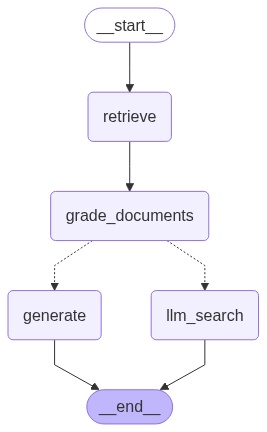

In [14]:
from IPython.display import Image, display

graph = run_workflow()
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass